<a href="https://colab.research.google.com/github/LucaForziati/nlp_coderhouse/blob/main/trabajo_final_true_fake_news_ForziatiGangi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fake news recognition**

El presente trabajo busca crear un sistema para detectar posibles notificas falsas; para ello se utilizará un dataset extraido de Kaggle que cuenta con noticias categorizadas como verdaderas y otras categorizadas como falsas.

#Librerias

importar librerias necesarias

In [ ]:
# pandas
import pandas as pd

# seaborn
import seaborn as sns

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

nltk.download('punkt')
nltk.download('stopwords')

# spacy
import spacy

#sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# regular expression
import re

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# modelo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#dataset

cargar datasets

In [ ]:
# cargar dataset de noticias falsas
fake_df = pd.read_csv("https://raw.githubusercontent.com/LucaForziati/nlp_coderhouse/refs/heads/main/dataset/Fake.csv")

# cargar dataset de notificas verdaderas
true_df = pd.read_csv("https://raw.githubusercontent.com/LucaForziati/nlp_coderhouse/refs/heads/main/dataset/True.csv")

In [ ]:
# observar info general del dataset de noticias falsas
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


Cuenta con 4 columnas y 23481 noticias.

No cuenta con datos nulos.

In [ ]:
# observar info general del dataset de noticias verdaderas
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


Cuenta con 4 columnas y 21417 noticias.

No cuenta con valores nulos.

In [ ]:
# visualziar dataset
true_df.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
# visualizar dataset
fake_df.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Preprocesamiento

## acomodar dataset

In [ ]:
# primeras 5000 noticias verdaderas
true = true_df[:5000]

# primeras 5000 noticias falsas
fake = fake_df[:5000]

De ambos dataset, me voy a quedar con 5000 entradas de cada una, generando asi un corpus de 10.000 noticias

In [ ]:
# Quedarse solo con la columna text

true = true[['text']]
fake = fake[['text']]

In [ ]:
# ver si hay duplicados en el dataset true
print(true.duplicated().sum())
# ver si hay duplicados en el dataset fake
print(fake.duplicated().sum())

38
0


hay valores repetidos en el dataset de noticias verdaderas.

In [ ]:
# eliminar filas duplicadas en el dataset fake
true.drop_duplicates(inplace=True)

El presente trabajo busca determinar si la noticia es falsa; por lo tanto, solo me quedaré con la columna 'text' de cada dataset.

In [ ]:
# atento que, en el dataset true, el mismo no comienza por la noticia. Se borrará esa inicial hasta el guion
true['text'] = true['text'].str.replace(r"^.*?-\s", "", regex=True)
fake['text'] = fake['text'].str.replace(r"^.*?-\s", "", regex=True)

In [ ]:
# agregar etiqueta a los datasets
true['status'] = 1
fake['status'] = 0

Con este establecemos un status de cuando una noticia es verdadera (1) y cuando una noticia es falsa (0).

In [ ]:
# dataset combinado
dataset = pd.concat([true, fake], ignore_index=True)
# mezclar el dataset unido
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head(5)

,text,status
0,Donald Trump and the people in his administrat...,0
1,Has anyone else noticed that the government so...,0
2,Donald Trump s list of allies is getting short...,0
3,Anti-vaccination advocates were hoping they co...,0
4,"Not too long ago, the Republican Party and Don...",0


Unimos ambos datasets y lo mezclamos

## convertir a minusculas y eliminar caracteres especiales

In [ ]:
# Convertir el texto a minúsculas
dataset['text'] = dataset['text'].str.lower()

In [ ]:
# Eliminar caracteres especiales y números
dataset['text'] = dataset['text'].str.replace(r'[^a-záéíóúñü\s]', '', regex=True)

## Tokenizar y stop words

In [ ]:
# Tokenizar cada noticia
dataset['text'] = dataset['text'].apply(word_tokenize)

dataset.head()

,text,status
0,"[donald, trump, and, the, people, in, his, adm...",0
1,"[has, anyone, else, noticed, that, the, govern...",0
2,"[donald, trump, s, list, of, allies, is, getti...",0
3,"[antivaccination, advocates, were, hoping, the...",0
4,"[not, too, long, ago, the, republican, party, ...",0


In [ ]:
# Stopwords en ingles
stop_words = set(stopwords.words('english'))

In [ ]:
# Eliminamos las stopwords
dataset['text'] = dataset['text'].apply(lambda x: [word for word in x if word not in stop_words])

# Mostramos el resultado
dataset.head()

,text,status
0,"[donald, trump, people, administration, precio...",0
1,"[anyone, else, noticed, government, sometimes,...",0
2,"[donald, trump, list, allies, getting, shorter...",0
3,"[antivaccination, advocates, hoping, could, co...",0
4,"[long, ago, republican, party, donald, trump, ...",0


## Lematizacion

In [ ]:
# Cargamos el modelo de spaCy en ingles
nlp = spacy.load('en_core_web_sm')

# Lematización usando spaCy
def lemmatize_text(text):
    doc = nlp(' '.join(text))
    return [token.lemma_ for token in doc]

dataset['text'] = dataset['text'].apply(lemmatize_text)

# Mostramos las palabras lematizadas
dataset.head()

,text,status
0,"[donald, trump, people, administration, precio...",0
1,"[anyone, else, notice, government, sometimes, ...",0
2,"[donald, trump, list, ally, get, short, outrag...",0
3,"[antivaccination, advocate, hope, could, conti...",0
4,"[long, ago, republican, party, donald, trump, ...",0


## TF-IDF

In [ ]:
df_final = dataset.copy()

In [ ]:
# Unir los tokens en strings
df_final['text'] = df_final['text'].apply(lambda x: ' '.join(x))
df_final

,text,status
0,donald trump people administration precious li...,0
1,anyone else notice government sometimes seem l...,0
2,donald trump list ally get short outrageous ac...,0
3,antivaccination advocate hope could continue e...,0
4,long ago republican party donald trump make di...,0
...,...,...
9957,fayetteville woman learn north carolina law pe...,0
9958,smithsonian museum africanamerican history ope...,0
9959,everyone know stephen colbert lay donald trump...,0
9960,top us business lobby china say tuesday concer...,1


In [ ]:
# Vectorizar el texto
vectorizer = TfidfVectorizer(max_features = 1000, ngram_range=(1,4))
X = vectorizer.fit_transform(df_final['text'])
y = df_final['status']

# Modelo

## regresion logistica

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6973, 1000), (2989, 1000), (6973,), (2989,))

In [ ]:
# Crear y entrenar el modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1448
           1       0.99      0.99      0.99      1541

    accuracy                           0.99      2989
   macro avg       0.99      0.99      0.99      2989
weighted avg       0.99      0.99      0.99      2989


Matriz de confusión:
[[1438   10]
 [  13 1528]]


<Axes: >

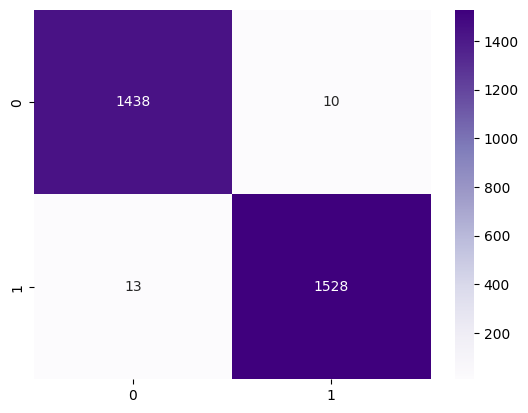

In [ ]:
cm_lg = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_lg, annot=True, cmap="Purples", fmt="d")

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')
print("Score en validación cruzada:", scores.mean())

Score en validación cruzada: 0.9891953131084733
